In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date, timedelta

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

august_2017_temps = calc_temps('2017-08-01', '2017-08-07')
august_2017_temps = august_2017_temps[0]

average_august_temp = round(august_2017_temps[1], 2)

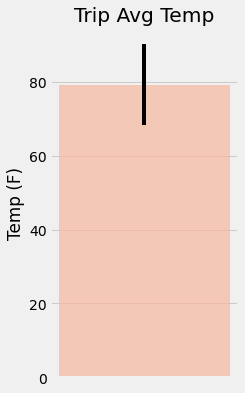

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = 1
error = august_2017_temps[2] - august_2017_temps[0]

plt.figure(figsize=(3,6))
plt.bar(x, average_august_temp, yerr=error,
        align='center',
        alpha=0.7,
        color='#F7B79F',
        width=0.01)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    labelbottom=False)
plt.grid(axis='x', alpha=0)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
measurement_results = session.query(measurement.station, func.sum(measurement.prcp)).\
                                    filter(measurement.date >= '2017-08-01').\
                                    filter(measurement.date <= '2017-08-07').\
                                    group_by(measurement.station).\
                                    order_by(measurement.prcp.desc()).all()

prcp_df = pd.DataFrame(measurement_results, columns=['station', 'prcp'])
prcp_df = prcp_df.sort_values('prcp', ascending=False)

station_results = session.query(station.id, station.station, station.name, station.latitude, station.longitude,  station.elevation).\
    order_by(station.id.asc()).all()

station_df = pd.DataFrame(station_results, columns=['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])
station_df.set_index('id', inplace=True)
station_df = station_df.dropna()
station_df.dtypes

station_prcp_df = prcp_df.merge(station_df, on='station', how='left')
station_prcp_df = station_prcp_df.rename(columns={'station': 'Station',
                                                  'prcp': 'Total Precipitation',
                                                  'name': 'Station Name',
                                                  'latitude': 'Latitude',
                                                  'longitude': 'Longitude',
                                                  'elevation': 'Elevation'})
station_prcp_df

,Station,Total Precipitation,Station Name,Latitude,Longitude,Elevation
0,USC00516128,0.36,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00514830,0.22,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00519281,0.06,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00519397,0.04,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [13]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = date(2017, 8, 1)
end_date = date(2017, 8, 7)

range_list = []
# Use the start and end date to create a range of dates
delta = end_date - start_date
for date in range(delta.days + 1):
    day = start_date + timedelta(days=date)
    
    # Strip off the year and save a list of strings in the format %m-%d
    day = day.strftime('%m-%d')
    range_list.append(day)

# Use the `daily_normals` function to calculate the normals for each date string
normals = []
def daily_normals(date):
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

for date in range_list:
    normals.append(daily_normals(date)[0])

In [14]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, index=range_list, columns=['Min', 'Avg', 'Max'])
trip_df

,Min,Avg,Max
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


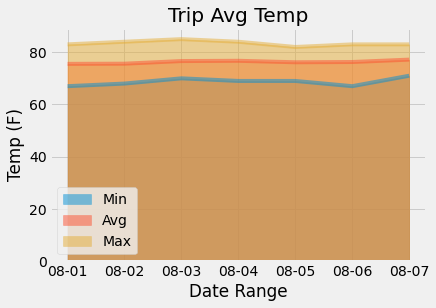

In [15]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False)
plt.title('Trip Avg Temp')
plt.xlabel('Date Range')
plt.ylabel('Temp (F)')
plt.show()

## Close Session

In [16]:
# Close Session
session.close()